## dbGaP FHIR Notebooks - Exercise 4

In this exercise, you will query the dbGaP study "Genetic Epidemiology of COPD (COPDGene)". 

The study investigates Chronic Obstructive Pulmonary Disease.

The dbGaP id for the study is phs000179.

Note: You can use this notebook with other dbGaP studies to which you have access. Some queries will need to be adjusted to the specifics of any study that you use.

### Learning Objectives and Key Concepts

- Query controlled access data using RAS
- Show data summaries
- Some understanding of resources that help understand the data in dbGaP studies
- Use a heatmap to give high level view of data per patient

## Motivation/Purpose
To make use of convenience functions to access a FHIR server, and to understand authorization methods specific to dbGaP

## Requisites
- Data Access to the COPDGene study
 -You must have been granted access to one or more dbGaP studies.
- Python
 -matplotlib

 ### Icons in this Guide
 📘 A link to a useful external reference related to the section the icon appears in  

 🖐 A hands-on section where you will code something or interact with the server  

For functional purposes working with a controlled access study is identical to the examples already shown. The differences are:
- Passing a RAS token which contains authorization for the dbGaP studies you have access to 
- Active steps to ensure the data are used within the Data Use Conditions you have agreed to for the datasets

FHIR security as described by HL7 deals with passing credentials in the request header. The standard RAS GA4GH Passport 1.2 standard passports are too large to be included in a header. Therefore a mechanism to obtain a smaller Task Specific Token (TST) has been created.

📘 Notes on FHIR security

The TST mechanism uses the central NIH RAS service for authentication, but then provides a smaller token. Use of this mechanism is not described here.

Typically the token is delivered to the Downloads folder by the web browser a user has used to visit the TST site.

For simplification the DbGapFHIR class handles adding the token to all requests it makes.

#TODO - a separate notebook explaining at lower level how to use the requests module to pass the TST.

In [3]:
from dbgap_fhir import DbGapFHIR
import os
API_KEY_PATH = '~/.keys/ncbi_api_key.txt'
FHIR_SERVER = 'https://dbgap-api.ncbi.nlm.nih.gov/fhir/x1'

with open(os.path.expanduser(API_KEY_PATH)) as f:  
    api_key = f.read()
    
mf = DbGapFHIR(FHIR_SERVER,
           api_key=api_key,
           passport='~/Downloads/task-specific-token.txt')


### Subjects in a Research Study
In this example we start with the dbGaP id for the COPDGene study; phs000179

As in Notebook 3 we can query for Patients registered to the study.

In [4]:
study_id = 'phs000179'

patients = mf.run_query(f"Patient?_has:ResearchSubject:individual:study={study_id}&_count=250")

Total  Resources: 10368
Total  Bytes: 4596302
Total  Pages: 42
Time elapsed 171.5340 seconds


In [5]:
patients[812]

{'resourceType': 'Patient',
 'id': '432602',
 'meta': {'tag': [{'system': 'https://dbgap-api.ncbi.nlm.nih.gov/fhir/x1/CodeSystem/DbGaP-Backend-Source',
    'code': 'Nitro',
    'display': 'Resource served by Nitro backend.'}]},
 'identifier': [{'id': '432602',
   'system': 'https://dbgap-api.ncbi.nlm.nih.gov/fhir/x1/CodeSystem/DbGaPConcept-DbGaPSubjectIdentifier'}],
 'gender': 'unknown'}

### How RAS affects query results from the FHIR server

For any query to which access is contolled by a RAS token the server will only return resources that you have access to.

* The same query by two different users will give different results
* The same user using two tokens  which authorize access for different sets of studies will give different results 



### Studies to which user has access
One benefit of the above is to provide a simple way to confirm what studies FHIR and the token have provided you access to.

In the following query Research subjects are selected based on their registration status on the study (status=on-study), and the query returns the studies to which they belong. Because access control is applied to the ResearchSubjects, only subjects from the studies to which the token authorizes access are returned.

In [6]:
studies = mf.run_query("ResearchStudy?_has:ResearchSubject:study:status=on-study")

Total  Resources: 31
Total  Bytes: 823971
Total  Pages: 1
Time elapsed 8.3608 seconds


We can do a simple conversion of the FHIR resources returned in the query to a Dataframe as follows.

In [7]:
sdict = []
for s in studies:
    sdict.append({'id':s['id'], 'title':s['title']})


import pandas as pd

df = pd.DataFrame.from_dict(sdict)
df.sort_values(by=['id'])

,id,title
25,phs000178,The Cancer Genome Atlas (TCGA)
12,phs000179,Genetic Epidemiology of COPD (COPDGene)
1,phs000209,Multi-Ethnic Study of Atherosclerosis (MESA) C...
30,phs000235,National Cancer Institute Cancer Genome Charac...
0,phs000614,Genomic Analysis of Pediatric Low Grade Gliomas
22,phs000748,Multiple Myeloma CoMMpass Study
2,phs000794,Longitudinal Genome-Wide Analysis of Patients ...
8,phs000892,CPTAC Proteogenomic Confirmatory Study
27,phs000951,NHLBI TOPMed: Genetic Epidemiology of COPD (CO...
4,phs001054,Genomic Characterization of Pediatric Low-Grad...


🖐 If of interest obtain two different TSTs and run the same query and add steps here compare the results you get.

### Look at COPDGene study details

Returning to the COPDGene study phs000179

### Retrieving Observations for Subjects in the study
We take the same approach as in notebook 3.

Because we have 10368 subjects, in the interests of time the for loop steps through every 100th subject. 
This will still take several minutes to retrieve all the results.

Note: more efficient ways of retrieiving the data are being explored. Feedback from users of these notebooks is encouraged to drive what features of the API would be useful. The slower methods here are useful for now as they allow us all to develop familiarity with the data, and to understand what API features would be most useful to work with the data. 

In [11]:
from ipywidgets import IntProgress
from IPython.display import display

prog = IntProgress(min=0, max=len(patients)) # instantiate the bar
display(prog) # display the bar

increment = 100

all_obs = []
patients_with_obs = []
for p in patients[10:len(patients):increment]:
    obs = mf.run_query(f"Observation?subject={p['id']}", show_stats=False)
    if len(obs)>0:
            all_obs += obs
            patients_with_obs.append(p)
    prog.value += increment
print(f"{len(patients_with_obs)} patients had observations")
print(f"{len(all_obs)} total observations")


IntProgress(value=0, max=10368)

104 patients had observations
25085 total observations


### Create a Dataframe
Use the same approach as in Notebook 3 to create a Dataframe where each row is a Subject and each column is an Observation

In [12]:
import pandas as pd
from collections import Counter


patient_observations_dict = {}
variable_definitions = {}
observations = []
obsCounter  = Counter()
codeCounter = Counter()
printObsCounts = False
rlimit = 20
nn = 0
for r in all_obs:

    if r['resourceType'] == 'Observation':
        subject_id = r['subject']['reference']
        obsCounter[subject_id] +=1
        obs_display_name = r['code']['coding'][0]['display']
        if 'valueQuantity' in r:
            value_text = r['valueQuantity']['value']
        elif 'valueCodeableConcept' in r:
             value_text = r['valueCodeableConcept']['coding'][0]['display']
        else:
            value_text = 'unknown'
        codeCounter[obs_display_name] +=1
        observations.append(r)
        
        if subject_id not in patient_observations_dict:
            patient_observations_dict[subject_id] = {obs_display_name: value_text}
        else:
            patient_observations_dict[subject_id][obs_display_name] = value_text
            
        var_def =  {"extension": r['extension'], "code":r['code']}
        if obs_display_name not in variable_definitions:
            variable_definitions[obs_display_name] = var_def



#Summarize
print(f"Number of patients with observations {len(obsCounter.keys())}")

if printObsCounts:
    print("Observation count per patient")
    print(json.dumps(obsCounter, indent=3))

df = pd.DataFrame.from_dict(codeCounter,  orient='index')
pd.set_option("display.max_rows", 30, "display.max_columns", None)
patient_df = pd.DataFrame.from_dict(patient_observations_dict, orient='index')



Number of patients with observations 104


The resulting dataframe is not displayed here because it contains the subject level data which is under access control.

The following are some summarizations that are possible.

It is beyond the scope of this tutorial to teach the use of matplotlib, numpy and other data science packages commonly used in Jupyter.
📘 See matpltlib

### Plot summary data for a variable

(Note: if you are using a study other than phs000179 it will be necessary to substitute different variable names in the examples that follow. The variables become the column names of the Dataframe created above. Review the Dataframe, along with the dbGaP pages for the study, for suitable variables)

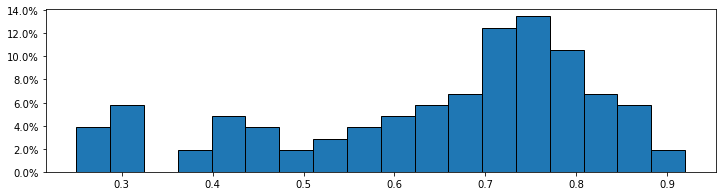

In [13]:
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,3))
ax = fig.gca()

plt.hist(patient_df['FEV1_FVC_pre'], 
         bins=18,
         weights=np.ones(len(patient_df)) / len(patient_df), 
         edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

This histogram is similar to those provided on the dbGaP variable report pages. 

📘 For comparison, the dbGaP variable page for the FEV1/FVC ratio in this study is available [here](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs000179.v6.p2&phv=159855). 

Use of the data analysis capabilities in Jupyter allows you to plot other selections of data besides those pre-computed on the dbGaP pages.

* Note that as we retrieved a subset of the patients the graph will not be identical to those on the variable page

#### Summary (descriptive) statistics 
Summary statistics similar to those on the variable pages can be obtained using simple Pandas fucntions. For example:

In [14]:
print(patient_df[['FEV1_FVC_pre']].describe())

       FEV1_FVC_pre
count    101.000000
mean       0.646040
std        0.174677
min        0.250000
25%        0.540000
50%        0.700000
75%        0.780000
max        0.920000


### Plotting your own variable histograms

The following function allows us to plot the frequency distribution of any variable, using any other variable to group the plots.

In [15]:
def plot_dbgap_var(var_name, covariate, df=None):
    
    if not type(df) == pd.core.frame.DataFrame:
        df = patient_df
    #fig = plt.figure(figsize=(12,3))
    plt.rcParams['figure.figsize'] = [12, 3]
    #ax = fig.gca()
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    covariate_vals = df[covariate].unique().tolist()
    for c in covariate_vals:
        cdf = df.loc[df[covariate] == c, var_name]
        plt.hist(cdf, alpha=0.5, label=c,
                weights=np.ones(len(cdf)) / len(patient_df))

    #add plot title and axis labels
    plt.title(f'{var_name} Distribution by {covariate}')
    plt.xlabel(var_name)
    plt.ylabel('Frequency')
    
    #add legend
    plt.legend(title=covariate)

    #display plot
    plt.show()

### Plotting different variables

The function created above is used here to plot FEV1/FVC ratio by whether the patient is affected by the disease. We'll start as simple as possible, before exploring more ad 


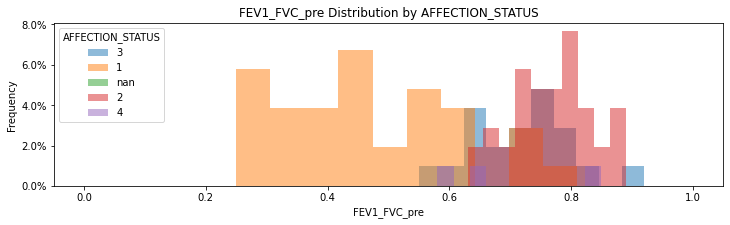

In [16]:
plot_dbgap_var('FEV1_FVC_pre', 'AFFECTION_STATUS')

📘 The [variable page](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs000179.v6.p2&phv=159563) for this Affection Status tells us the values mean
* 1- Case
* 2- Control
* 3- Other
* 4- Exclusionary Disease

The variable page also 

Note: in this notebook manual methods are used to find out this information (metadata) about the variables in a dataset. There are machine readable sources of these metadata, and approaches to working with them which will be discussed. 

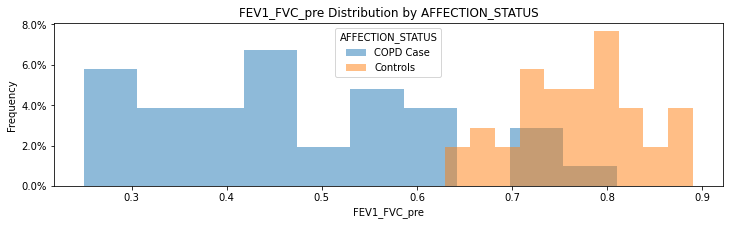

In [17]:
# Create a dictionary key-value pairs to translate Affection status to something meaningful.
affection_status_map = {'1' : 'COPD Case', '2' : 'Controls'}

# subset the data for only cases and controls 
sub_df = patient_df.loc[patient_df['AFFECTION_STATUS'].isin(['1','2'])]

# Use our dictionary to translate affection status 
sub_df = sub_df.replace({"AFFECTION_STATUS": affection_status_map})

# Plot the new dataframe
plot_dbgap_var('FEV1_FVC_pre', 'AFFECTION_STATUS', df=sub_df)

The fact that cases divide from controls is likely a reflection of the fact that FEV1/FVC ratio is used as a diagnostic criterion for COPD. The cutoff seems to be at a value of approximately 6.4. That there are subjects designated with ratios in the 0.7-0.8 range indicates that the FEV1/FVC ratio was not the only reason why a subject was diagnosed as a COPD case.

#### What have we learnt?
One might say the example above teaches us nothing new. While that might be true from a biological point of view, the learning here is intended to be how the dbGaP API interoprates with standard data science tools enables exploration of data.

#### Looking for more biological insight
The interoperability of dbGaP and Python tools allows more flexibility than the limited range of reports or graphs that one could expect dbGaP to provide for common 'use cases'. 

Here's an example where we can use that flexibility to explore a question where the answer is less obvious than in our previous example. Here the variable plotted (oxygen saturation) is less confounded with the grouping variable.

The oxygen saturation shows a wider range in COPD cases, but many are in the higher range found in the controls.



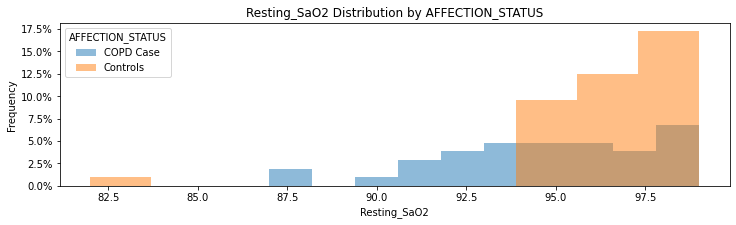

In [18]:
plot_dbgap_var('Resting_SaO2', 'AFFECTION_STATUS', df=sub_df)

🖐 The few controls with low oxygen saturations are interesting. There is always more to explore in a dataset. How could you investigate that using these tools and data?

🖐 Rather than the overlapped plots above, dbGaP variable pages plot the frequency distributions for each subgroup as separate histograms. According to need, that might be more suitable. You may wish to explore how a different version of the plot_dbgap_var function above could emulate the layout on the dbGaP variable pages. 

🖐 One of the machine readable dictionaries for the data from COPDGene provides the values of the codes for affection status. The dictionary is available at [this link](https://ftp.ncbi.nlm.nih.gov/dbgap/studies/phs000179/phs000179.v6.p2/pheno_variable_summaries/phs000179.v6.pht002237.v3.COPDGene_Subject.data_dict.xml). How might that machine readable metadata be used to automate the manual lookup of variable details that was used above?

If you do any of the above you might also consider submitting it to this GitHub repository.

### Making it interactive

The approaches above still relied on writing code to plot each variable combination of interest. If you want to explore many variable relationships you could plot them individually or make use of iPython's interactive features as in the following example.


The following step retrieves lists of variables that will be used in our interactive interface

In [19]:
import json
with open("data/COPDGene_interactive_vars.json") as f:
    ivars = json.load(f)
varlist = ivars['dependent_vars']
independent_vars = ivars['independent_vars']

In [20]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image, display
from io import BytesIO

vars = patient_df.columns.tolist()
@interact
def var_selector(varname=widgets.Dropdown(options = varlist, description = "Variable"),
                covariate=widgets.Dropdown(options = independent_vars, description = "Group by")
                ):
    plot_dbgap_var(varname, covariate)

interactive(children=(Dropdown(description='Variable', options=('PEF_post', 'diasBP', 'HR', 'O2_Therapy', 'O2_…

### Visualization
Use a heatmap to show a high level view of the observation by patient table

In [21]:
# create dataframe
heatmap_df = pd.DataFrame.from_dict(patient_observations_dict, orient='index')
# convert to 0,1 based on whether null or not
df2 = heatmap_df.notnull().astype("int")


In [22]:
import matplotlib

def observation_heat_map(plot_df, study_label):
    cmap = matplotlib.colors.ListedColormap(['xkcd:eggshell', 'green'])
    #fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(plot_df, cmap='Greens')
    ax.set_xlabel('Observation')
    ax.set_ylabel('Subject')
    ax.set_title(f'Observations present per subject in {study_label}')


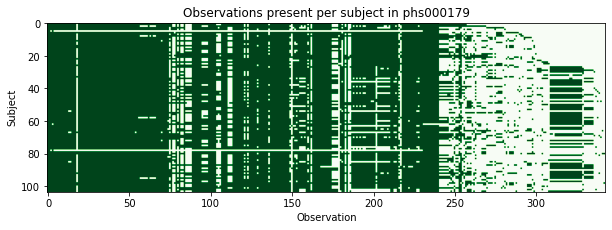

In [23]:
observation_heat_map(df2, study_id)